In [ ]:
!pip install torch_geometric
! gdown --id 13a_iNnu-ck76mHZ1gW6DP6zCjKZQE_QM
! gdown --id 1J_0fYPou7fl2rPPSHjdFZkGiq2DmU-5c
! gdown --id 1OrmrjmecPSGRoH5HzdB7NsFXWP8MgtPI 
! gdown --id 1_zz68sRVfEtDTHTOqI1w0ZhdDrUTHhCo

import os
import pandas as pd
import numpy as np
import random
import pickle
from numpy.linalg import norm
from collections import Counter
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import from_networkx, to_networkx
from IPython.display import clear_output 

clear_output()

In [ ]:
# Read the data
train_df = pd.read_csv('training_data.csv')
valid_df = pd.read_csv('cross_validation_dataset.csv')

display(train_df.head())
display(valid_df.head())

,Month #,White Player #,Black Player #,Score
0,1,73,1246,0.5
1,1,73,5097,0.5
2,1,73,5104,0.5
3,1,73,7321,1.0
4,1,73,7375,0.5


,Month #,White Player #,Black Player #,Score
0,96,4,2084,0.5
1,96,36,4562,0.5
2,96,36,4960,0.0
3,96,56,2552,0.5
4,96,143,2042,1.0


## Pre-processing

In [ ]:
players = np.union1d(train_df['White Player #'].unique(), train_df['Black Player #'].unique()) # get all unique player IDs
player_map = dict(zip(players, range(len(players))))  # create a mapping from player ID to new index

train_df['White Player #'] = train_df['White Player #'].map(player_map)  # map player A IDs to new index
train_df['Black Player #'] = train_df['Black Player #'].map(player_map)  # map player B IDs to new index

valid_df['White Player #'] = valid_df['White Player #'].map(player_map)  # all players in valid_df are present in train_df
valid_df['Black Player #'] = valid_df['Black Player #'].map(player_map)  

In [ ]:
# For each month and each player, create a feature 
# list [# games played as white, mean score for white games, #...black, ...black games]

def PlayerData(dataFrame):
    PlayerData = pd.DataFrame(columns=['Month #', 'Player #', 'Feature_Vector'])

    # Grouping the data by month and player separately
    grouped_white = dataFrame.groupby(['Month #', 'White Player #'])
    grouped_black = dataFrame.groupby(['Month #', 'Black Player #'])
    
    # Iterating over the groups
    for name_white, group_white in grouped_white:
        month, white_player = name_white

        # Computing feature vectors for white player
        white_games_count = len(group_white)
        white_avg_score = group_white['Score'].mean()

        # Checking if the white player also played as black in the same month
        if (month, white_player) in grouped_black.groups:
            group_black = grouped_black.get_group((month, white_player))
            black_games_count = len(group_black)
            black_avg_score = group_black['Score'].mean()
        else:
            black_games_count = 0.0
            black_avg_score = 0.0

        # Creating the feature vector
        feature_vector = [white_games_count, white_avg_score, black_games_count, black_avg_score]

        # Appending the row to PlayerData dataframe
        PlayerData = pd.concat([PlayerData, 
                                pd.DataFrame({'Month #': [month],
                                              'Player #': [white_player],
                                              'Feature_Vector': [feature_vector]})], 
                              ignore_index=True)
        
    # Handling players who played as black but not white
    for name_black, group_black in grouped_black:
        month, black_player = name_black
        
        # Checking if the black player did not play as white in the same month
        if (month, black_player) not in grouped_white.groups:
            black_games_count = len(group_black)
            black_avg_score = group_black['Score'].mean()
            
            # Creating the feature vector
            feature_vector = [0.0, 0.0, black_games_count, black_avg_score]
            
            # Appending the row to PlayerData dataframe
            PlayerData = pd.concat([PlayerData, 
                                    pd.DataFrame({'Month #': [month],
                                                  'Player #': [black_player],
                                                  'Feature_Vector': [feature_vector]})], 
                                  ignore_index=True)
    return PlayerData

train_PD = PlayerData(train_df)
valid_PD = PlayerData(valid_df)

train_PD.head()

,Month #,Player #,Feature_Vector
0,1,61,"[5, 0.6, 3, 0.3333333333333333]"
1,1,75,"[3, 0.8333333333333334, 3, 0.6666666666666666]"
2,1,130,"[1, 0.0, 0.0, 0.0]"
3,1,134,"[1, 1.0, 1, 0.5]"
4,1,159,"[1, 1.0, 0.0, 0.0]"


In [ ]:
# average the scores for games with same players (preserving White vs Black)
train_df = train_df.groupby(['Month #', "White Player #", "Black Player #"]).mean().reset_index()
valid_df = valid_df.groupby(['Month #', "White Player #", "Black Player #"]).mean().reset_index()

train_df.head()

,Month #,White Player #,Black Player #,Score
0,1,61,1066,0.5
1,1,61,4303,0.5
2,1,61,4308,0.5
3,1,61,6195,1.0
4,1,61,6243,0.5


In [ ]:
#Create a dictionary with months as keys and a directed nx graph representing the games played
#Direction of edge is:  white player --> black player with the mean score as weight
#Nodes are players with attributes: the PlayerData vector

def Create_Graph_Dict(dataFrame, PlayerData):
    # Group the dataframe by month
    grouped_df = dataFrame.groupby("Month #")

    # Iterate over each month and create a networkx graph
    graphs = {}
    for month, month_df in grouped_df:
        # Create an empty directed graph for the month
        graph = nx.DiGraph()

        # Iterate over the rows of the month dataframe
        for index, row in month_df.iterrows():
            white_player = int(row["White Player #"])
            black_player = int(row["Black Player #"])
            score = row["Score"]

            # Add nodes for the white and black players with their IDs as node attributes
            graph.add_node(white_player, ID=white_player, rank=PlayerData.loc[(PlayerData['Month #'] == month) & (PlayerData['Player #'] == white_player), 'Feature_Vector'].values[0])
            graph.add_node(black_player, ID=black_player, rank=PlayerData.loc[(PlayerData['Month #'] == month) & (PlayerData['Player #'] == black_player), 'Feature_Vector'].values[0])

            # Add an edge from the white player to the black player with the score as the edge attribute
            graph.add_edge(white_player, black_player, score=score)

        # Add the graph for the month to the dictionary
        graphs[month] = graph
    
    return graphs

In [ ]:
# Check if the graphs had been created
train_file_path = "train_dictionary.pickle"
valid_file_path = "valid_dictionary.pickle"

if os.path.exists(train_file_path):
    with open(train_file_path, "rb") as file:
        train_graphs = pickle.load(file)
else:
    train_graphs = Create_Graph_Dict(train_df, train_PD) 
    with open(train_file_path, "wb") as file:
        pickle.dump(train_graphs, file)

if os.path.exists(valid_file_path):
    with open(valid_file_path, "rb") as file:
        valid_graphs = pickle.load(file)
else:
    valid_graphs = Create_Graph_Dict(valid_df, valid_PD)  

    with open(valid_file_path, "wb") as file:
        pickle.dump(valid_graphs, file)


In [ ]:
# Example: Print the nodes and edges for some random months
random_months = random.sample(range(1, 101), 3)
for month in random_months:
    print(f"Month: {month}")
    print("Nodes:", train_graphs[month].nodes(data=True))
    print("Edges:", train_graphs[month].edges(data=True))
    print()

Month: 64
Nodes: [(64, {'ID': 64, 'rank': [3, 0.6666666666666666, 1, 0.5]}), (1738, {'ID': 1738, 'rank': [2, 0.25, 2, 1.0]}), (2684, {'ID': 2684, 'rank': [3, 0.8333333333333334, 3, 0.3333333333333333]}), (5136, {'ID': 5136, 'rank': [3, 0.6666666666666666, 2, 0.75]}), (134, {'ID': 134, 'rank': [2, 0.5, 2, 0.25]}), (1939, {'ID': 1939, 'rank': [2, 0.5, 2, 0.5]}), (7011, {'ID': 7011, 'rank': [2, 0.25, 2, 0.75]}), (157, {'ID': 157, 'rank': [2, 0.75, 2, 0.25]}), (888, {'ID': 888, 'rank': [1, 0.5, 1, 1.0]}), (5273, {'ID': 5273, 'rank': [0.0, 0.0, 2, 0.25]}), (186, {'ID': 186, 'rank': [1, 1.0, 1, 1.0]}), (2059, {'ID': 2059, 'rank': [1, 0.0, 1, 1.0]}), (219, {'ID': 219, 'rank': [5, 0.3, 2, 0.0]}), (330, {'ID': 330, 'rank': [1, 1.0, 4, 0.625]}), (1408, {'ID': 1408, 'rank': [2, 1.0, 2, 0.0]}), (1636, {'ID': 1636, 'rank': [2, 0.25, 5, 0.7]}), (2948, {'ID': 2948, 'rank': [1, 0.0, 4, 0.25]}), (5207, {'ID': 5207, 'rank': [4, 0.25, 4, 0.375]}), (325, {'ID': 325, 'rank': [1, 0.5, 1, 0.0]}), (4160, {'ID

In [ ]:
# Sort the list of nxGraphID-nxGraph tuples based on ID (month)
train_graph_tuples = sorted( [(graph_id, graph) for graph_id, graph in train_graphs.items()], key=lambda x: x[0] )
valid_graph_tuples = sorted( [(graph_id, graph) for graph_id, graph in valid_graphs.items()], key=lambda x: x[0] )

# Get a sorted list of nx Graphs
train_nxGraph_list = [graph for _, graph in train_graph_tuples]
valid_nxGraph_list = [graph for _, graph in valid_graph_tuples]

# Extract the sorted graphs and convert them to pytorch Data
train_Data_list = [from_networkx(graph) for graph in train_nxGraph_list]
valid_Data_list = [from_networkx(graph) for graph in valid_nxGraph_list]

In [ ]:
test_graph = train_Data_list[-1].clone()

mask_size = 300 # mask 300 edges
mask = torch.ones(test_graph.score.size(0), dtype=torch.bool)
mask[-mask_size:] = False

## Exploration

In [ ]:
def plot_degree_distribution(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    plt.xlabel("Degree")
    plt.show()

In [ ]:
def print_graph_stats(G):
    print("Number of nodes:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    print("")

    communities = nx.community.louvain_communities(G)
    print("Number of clusters:", len(communities))
    print("Modularity:", nx.community.modularity(G, communities))
    print("Average clustering coefficient:", nx.average_clustering(G))
    print("")

    print("Graph is strongly connected:", nx.is_strongly_connected(G))
    print("Graph is weakly connected:", nx.is_weakly_connected(G))
    print("Number of strongly connected components:", nx.number_strongly_connected_components(G))
    print("Number of weakly connected components:", nx.number_weakly_connected_components(G))

### Analysis of Different Months

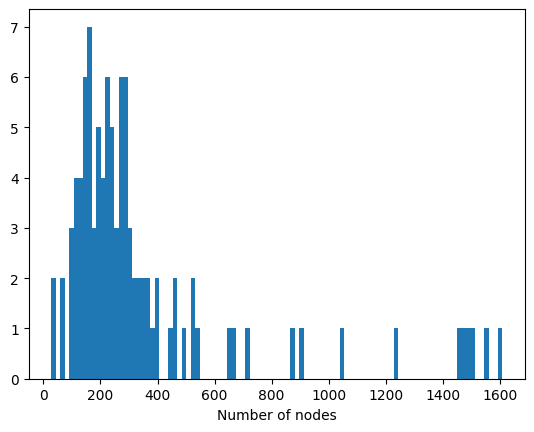

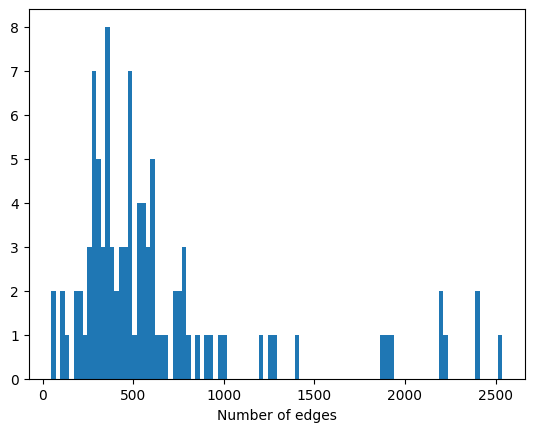

In [ ]:
# The goal here is to see whether all months have a similar number of players/games

num_nodes = []
num_edges = []
for month in train_graphs:
    G = train_graphs[month]
    num_nodes.append(G.number_of_nodes())
    num_edges.append(G.number_of_edges())

plt.figure(1)
plt.hist(num_nodes, bins=100)
plt.xlabel("Number of nodes")

plt.figure(2)
plt.hist(num_edges, bins=100)
plt.xlabel("Number of edges")

plt.show()

In [ ]:
print("Month 100 has " + str(train_graphs[100].number_of_nodes()) + " nodes and "
 + str(train_graphs[100].number_of_edges()) + " edges.")

Month 100 has 1231 nodes and 1938 edges.


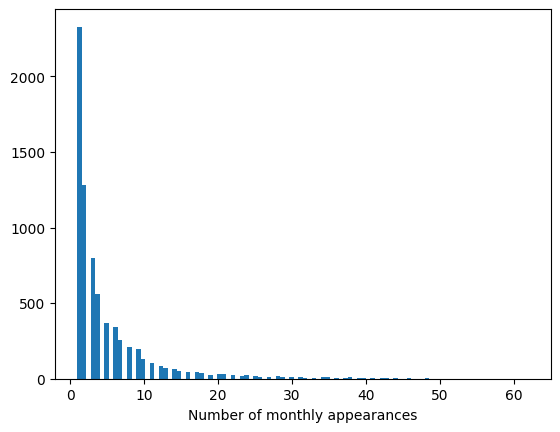

In [ ]:
node_freq = {}
for month in train_graphs:
    G = train_graphs[month]
    for u in G.nodes():
        if u not in node_freq:
            node_freq[u] = 1
        else:
            node_freq[u] += 1

vals = node_freq.values()
plt.hist(vals, bins=100)
plt.xlabel("Number of monthly appearances")
plt.show()

### Analysis of the Full Graph

In [ ]:
# Analysis of the graph that contains all 100 months
G_all = train_graphs[1]
for i in range(2, 101):
    G_all = nx.compose(G_all, train_graphs[i])

In [ ]:
print_graph_stats(G_all)

Number of nodes: 7301
Number of edges: 60046

Number of clusters: 523
Modularity: 0.49972620442525784
Average clustering coefficient: 0.10465317728453757

Graph is strongly connected: False
Graph is weakly connected: False
Number of strongly connected components: 1625
Number of weakly connected components: 77


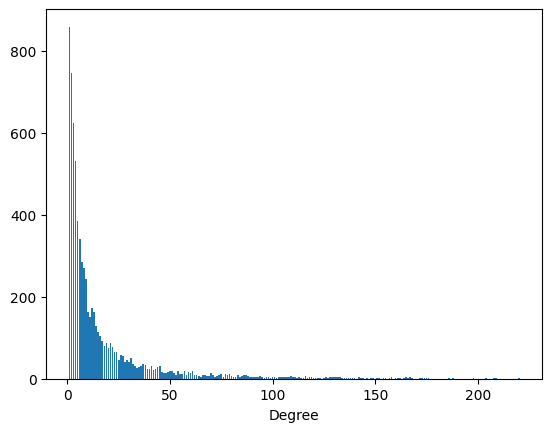

In [ ]:
plot_degree_distribution(G_all)

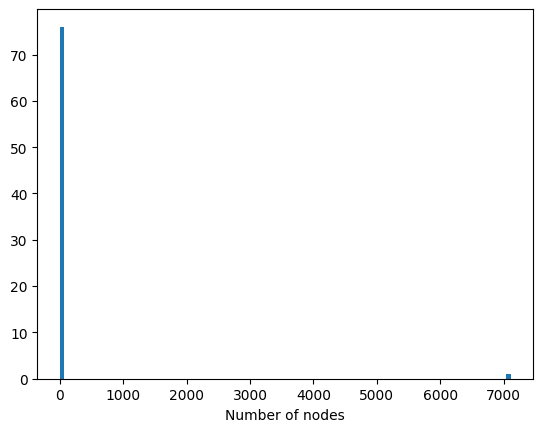

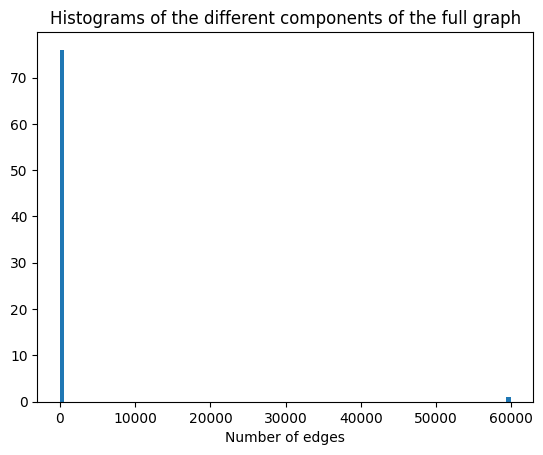

In [ ]:
all_comps = nx.weakly_connected_components(G_all)
num_nodes = []
num_edges = []
for G in all_comps:
    G = G_all.subgraph(list(G))
    num_nodes.append(G.number_of_nodes())
    num_edges.append(G.number_of_edges())

plt.figure(1)
plt.hist(num_nodes, bins=100)
plt.xlabel("Number of nodes")
plt.figure(2)
plt.hist(num_edges, bins=100)
plt.xlabel("Number of edges")

plt.title("Histograms of the different components of the full graph")

plt.show()

#### Analysis of Giant Component

In [ ]:
#Let's further analyze the giant component of G_all
largest_cc = max(nx.weakly_connected_components(G_all), key=len)
G_cc = nx.induced_subgraph(G_all, list(largest_cc))

In [ ]:
print_graph_stats(G_cc)

Number of nodes: 7115
Number of edges: 59921

Number of clusters: 507
Modularity: 0.48659266517807215
Average clustering coefficient: 0.10642860351666558

Graph is strongly connected: False
Graph is weakly connected: True
Number of strongly connected components: 1449
Number of weakly connected components: 1


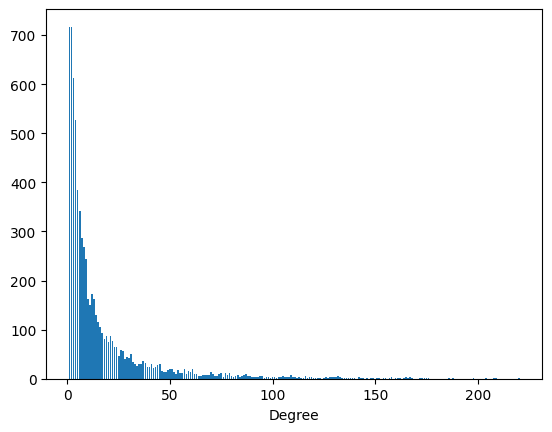

In [ ]:
plot_degree_distribution(G_cc)

### Link Analysis

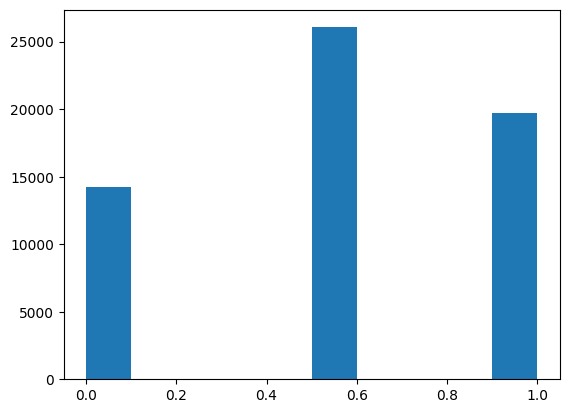

In [ ]:
scores = []
for e in G_all.edges.data():
    scores.append(e[2]['score'])
plt.hist(scores)
plt.show()

## Baseline 1: Matrix Completion

In [ ]:
# get data for the last month games
month_100 = train_df[train_df['Month #'] == 100]
players_100 = np.union1d(month_100['White Player #'].unique(), month_100['Black Player #'].unique())
players_100_map = dict(zip(players_100, range(len(players_100))))  # create a special mapping for the last players

month_100['White Player #'] = month_100['White Player #'].map(players_100_map)
month_100['Black Player #'] = month_100['Black Player #'].map(players_100_map)


# initialize array C with dimensions (#players in month_100, #players in month_100)
# entry (i,j) is the result of the game where player i played as white against player j
C = np.full((len(players_100), len(players_100)), np.nan, dtype=np.float32)

# update C array with game results for each row in the dataframe
for _, row in month_100.iterrows():
    playerA_index = int(row['White Player #'])  
    playerB_index = int(row['Black Player #'])  

    if np.isnan(C[playerA_index, playerB_index]):  # if no game result has been recorded yet
        C[playerA_index, playerB_index] = np.float32(row['Score'])
    else:  # if a game result has already been recorded for this month
        count = np.count_nonzero(~np.isnan(C[playerA_index, playerB_index]))  # count the number of non-NaN values
        total_score = C[playerA_index, playerB_index] * count + np.float32(row['Score'])  # calculate the sum of scores
        C[playerA_index, playerB_index] = total_score / (count + 1)  # calculate the average score

In [ ]:
# Alternating Least Squares for Completion of Matrices with nan values
def als(X, rank=10, max_iter=10):
    '''
    X: matrix to be completed
    rank: rank of the factorizing matrices, W and Z
    max_iter: maximum number of iterations
    '''

    m, n = X.shape
    W = np.random.rand(m, rank)
    Z = np.random.rand(n, rank)

    for _ in range(max_iter):
        # fix W, optimize Z
        for j in range(n):
            non_nan = np.where(~np.isnan(X[:, j]))[0]
            Z[j,:] = np.linalg.lstsq(W[non_nan,:], X[non_nan,j], rcond=None)[0]

        # fix Z, optimize W
        for i in range(m):
            non_nan = np.where(~np.isnan(X[i, :]))[0]
            W[i,:] = np.linalg.lstsq(Z[non_nan,:], X[i,non_nan], rcond=None)[0]

    non_nan = np.where(~np.isnan(X))
    L = norm(X[non_nan] - np.dot(W, Z.T)[non_nan])**2
    return W, Z, L/2

# Example usage
# X = np.array([[1, np.nan, 0], [3, 0, 4], [0, 5, np.nan]])
# W, Z, L = als(X)
# print("W:\n", W)
# print("Z:\n", Z)
# print("L(W,Z) = ", L)


In [ ]:
masked_edges_in_C = [(players_100_map[ test_graph.ID[u].item() ], players_100_map[ test_graph.ID[v].item() ]) for u,v in test_graph.edge_index[:,-mask_size:].T]
C_masked = C.copy()

for i,j in masked_edges_in_C:
  C_masked[i,j] = np.nan # set masked edge scores to nan

In [ ]:
# fill in missing values in C
C_filled = np.zeros(C.shape, dtype=np.float32)

W, Z, L = als(C_masked)
C_filled = np.dot(W, Z.T)

# digitize the values
C_filled[C_filled < 1/3] = 0
C_filled[C_filled > 2/3] = 1
C_filled[(C_filled >= 1/3) & (C_filled <= 2/3)] = 0.5

print(C_filled)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.5 0.5]
 ...
 [0.  1.  0.  ... 0.  0.  1. ]
 [0.  0.5 0.  ... 0.  0.  0.5]
 [0.  0.5 0.  ... 0.  0.  0. ]]


Before calculating the accuracy of the predicted scores by the filled matrix, let us make sure that the matrix really approximated C_masked on non-nan entries

In [ ]:
# test the performance of the C_filled by comparing it to the C_masked on non-nan entries
print("Squared Frobenius norm of the residual matrix: ", L)


Squared Frobenius norm of the residual matrix:  1.0702636172709536e-28


With a decent performance, we can now test the accuracy of our first baseline model

In [ ]:
predicted_scores = [ C_filled[i,j] for i,j in masked_edges_in_C ]
ground_truth = [ C[i,j] for i,j in masked_edges_in_C ]

correct_predictions = sum(1 for pred, true in zip(predicted_scores, ground_truth) if pred == true)
total_predictions = len(predicted_scores)
accuracy = correct_predictions / total_predictions * 100

print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 29.00%


## Baseline 2:  Standard GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels=4, out_channels=8):
        super(GCN, self).__init__()

        #node embedding
        self.conv1 = GCNConv(in_channels, 4 * in_channels)
        self.conv2 = GCNConv(4 * in_channels, 4 * out_channels)
        self.conv3 = GCNConv(4 * out_channels, 4 * out_channels)
        self.conv4 = GCNConv(4 * out_channels, 2 * out_channels)

        self.fc = torch.nn.Linear(2 * out_channels, out_channels)

        self.dropout = torch.nn.Dropout(p=0.1)
        
        #edge embedding and classification
        self.mlp = nn.Sequential(
            nn.Linear(2*out_channels, 8 * out_channels),
            nn.ELU(),  

            nn.Linear(8 * out_channels, 16 * out_channels),
            nn.ELU(),

            nn.Linear(16 * out_channels, 32 * out_channels),
            nn.ELU(),

            nn.Linear(32 * out_channels, 16 * out_channels),
            nn.ELU(),

            nn.Linear(16 * out_channels, 8 * out_channels),
            nn.ELU(),

            nn.Linear(8 * out_channels, 4 * out_channels),
            nn.ELU(),

            nn.Linear(4 * out_channels, 3),
        )

    
    def forward(self, data):
        node_features, edge_index = data.rank.view(-1,data.rank.shape[1]).to(torch.float), data.edge_index

        node_features = self.conv1(node_features, edge_index)
        node_features = F.elu(node_features)
        node_features = self.dropout(node_features)

        node_features = self.conv2(node_features, edge_index)
        node_features = F.elu(node_features)
        node_features = self.dropout(node_features)

        node_features = self.conv3(node_features, edge_index)
        node_features = F.elu(node_features)
        node_features = self.dropout(node_features)

        node_features = self.conv4(node_features, edge_index)
        node_features = F.elu(node_features)

        node_features = self.fc(node_features)

        # Concatenate node embeddings to compute edge features
        src, dst = edge_index
        edge_features = torch.cat([node_features[src], node_features[dst]], dim=1)
        edge_features = self.mlp(edge_features)

        return edge_features


### Training

In [ ]:
# function used to classify the scores to classes
def send_to_class(tensor):
    tensor_mapped = torch.zeros_like(tensor, device=tensor.device) 
    tensor_mapped[tensor < 1/3] = 0
    tensor_mapped[(tensor >= 1/3) & (tensor < 2/3)] = 1
    tensor_mapped[tensor >= 2/3] = 2
    return tensor_mapped.long()

In [ ]:
def train_gcn(train_Data_list, valid_Data_list, early_stopping_rounds=10, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model and optimizer
    model = GCN().to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()  

    # Initialize variables for tracking best validation loss and early stopping
    best_valid_loss = float('inf')
    early_stopping_counter = 0

    # Train for a fixed number of epochs
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0
        train_correct = 0
        valid_correct = 0
        train_samples = 0
        valid_samples = 0

        # Train on training dataset
        model.train()
        for i, graph in enumerate(train_Data_list):
            graph = graph.to(device)
            optimizer.zero_grad()
            out = model(graph)

            if i == 99:  # if it's the test graph, use the mask
                loss = loss_fn(out[mask, :], send_to_class(graph.score[mask]))  
                train_samples += graph.edge_index.size(1) - mask_size
            else:
                loss = loss_fn(out, send_to_class(graph.score))  
                train_samples += graph.edge_index.size(1)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted_classes = torch.max(out, 1)
            correct = (predicted_classes == send_to_class(graph.score)).sum()
            train_correct += correct.item()

        # Evaluate on validation dataset
        model.eval()
        with torch.no_grad():
            for graph in valid_Data_list:
                graph = graph.to(device)
                out = model(graph)

                # Calculate validation loss
                valid_loss += loss_fn(out, send_to_class(graph.score)).item()  

                # Calculate validation accuracy
                _, predicted_classes = torch.max(out, 1)
                correct = (predicted_classes == send_to_class(graph.score)).sum()
                valid_correct += correct.item()
                valid_samples += graph.edge_index.size(1)

        # Calculate average loss and accuracy for epoch
        train_loss /= len(train_Data_list)
        valid_loss /= len(valid_Data_list)
        train_accuracy = train_correct / train_samples
        valid_accuracy = valid_correct / valid_samples

        # Print loss and accuracy for epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Accuracy: {valid_accuracy:.4f}")

        # Check if validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stopping_counter = 0

            # Save the model weights
            torch.save(model.state_dict(), 'best_GCN_model_weights.pth')

        else:
            early_stopping_counter += 1

        # Check if early stopping criteria has been met
        if early_stopping_counter >= early_stopping_rounds:
            print(f"Validation loss did not improve for {early_stopping_rounds} epochs. Training stopped.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('best_GCN_model_weights.pth'))

    return model


In [ ]:
trained_gcn = train_gcn(train_Data_list, valid_Data_list)

Epoch 1/20, Train Loss: 1.0584, Train Accuracy: 0.4535, Valid Accuracy: 0.5293
Epoch 2/20, Train Loss: 1.0355, Train Accuracy: 0.4753, Valid Accuracy: 0.5338
Epoch 3/20, Train Loss: 1.0323, Train Accuracy: 0.4768, Valid Accuracy: 0.5120
Epoch 4/20, Train Loss: 1.0262, Train Accuracy: 0.4793, Valid Accuracy: 0.5379
Epoch 5/20, Train Loss: 1.0226, Train Accuracy: 0.4818, Valid Accuracy: 0.5397
Epoch 6/20, Train Loss: 1.0187, Train Accuracy: 0.4855, Valid Accuracy: 0.5438
Epoch 7/20, Train Loss: 1.0236, Train Accuracy: 0.4783, Valid Accuracy: 0.5243
Epoch 8/20, Train Loss: 1.0229, Train Accuracy: 0.4835, Valid Accuracy: 0.5432
Epoch 9/20, Train Loss: 1.0191, Train Accuracy: 0.4860, Valid Accuracy: 0.5435
Epoch 10/20, Train Loss: 1.0158, Train Accuracy: 0.4864, Valid Accuracy: 0.5413
Epoch 11/20, Train Loss: 1.0124, Train Accuracy: 0.4887, Valid Accuracy: 0.5527
Epoch 12/20, Train Loss: 1.0159, Train Accuracy: 0.4890, Valid Accuracy: 0.5527
Epoch 13/20, Train Loss: 1.0140, Train Accuracy: 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_gcn.eval()
with torch.no_grad():
    test_graph = test_graph.to(device)
    results = trained_gcn(test_graph)

    # Calculate accuracy
    _, predicted_classes = torch.max(results, 1)
    correct = (predicted_classes[~mask] == send_to_class(test_graph.score[~mask])).sum().item()
    accuracy = correct / test_graph.score[~mask].size(0) * 100

    print(f'Accuracy: {accuracy:.4} %')


Accuracy: 62.33 %


## SAGE Encoder-Decoder

### Model

In [ ]:
class BidirectionalSAGE(torch.nn.Module):
    def __init__(self, in_channels=4, out_channels=8):
        super(BidirectionalSAGE, self).__init__()

        #node embedding
        self.conv1 = SAGEConv(in_channels, 4 * in_channels)
        self.conv2 = SAGEConv(4 * in_channels, 4 * out_channels)
        self.conv3 = SAGEConv(4 * out_channels, 4 * out_channels)
        self.conv4 = SAGEConv(4 * out_channels, 2 * out_channels)

        self.fc = torch.nn.Linear(2 * out_channels, out_channels)

        self.dropout = torch.nn.Dropout(p=0.1)
        
        #edge embedding and classification
        self.mlp = nn.Sequential(
            nn.Linear(out_channels, 4 * out_channels),
            nn.ELU(),  

            nn.Linear(4 * out_channels, 8 * out_channels),
            nn.ELU(),

            nn.Linear(8 * out_channels, 16 * out_channels),
            nn.ELU(),

            nn.Linear(16 * out_channels, 32 * out_channels),
            nn.ELU(),

            nn.Linear(32 * out_channels, 16 * out_channels),
            nn.ELU(),

            nn.Linear(16 * out_channels, 8 * out_channels),
            nn.ELU(),

            nn.Linear(8 * out_channels, 4 * out_channels),
            nn.ELU(),

            nn.Linear(4 * out_channels, 1),
            nn.Sigmoid()
        )

    
    def forward(self, data, encode=True):
        node_features, edge_index = data.rank.view(-1,data.rank.shape[1]).to(torch.float), data.edge_index

        if encode:
            #encoder

            # Forward message passing: source to target
            out1 = self.conv1(node_features, edge_index)
            out1 = F.elu(out1)
            out1 = self.dropout(out1)

            out1 = self.conv2(out1, edge_index)
            out1 = F.elu(out1)
            out1 = self.dropout(out1)

            out1 = self.conv3(out1, edge_index)
            out1 = F.elu(out1)
            out1 = self.dropout(out1)

            out1 = self.conv4(out1, edge_index)
            out1 = F.elu(out1)

            # Reverse the edge direction
            edge_index_reverse = torch.flip(edge_index, [0])

            # Backward message passing: target to source
            out2 = self.conv1(node_features, edge_index)
            out2 = F.elu(out2)
            out2 = self.dropout(out2)

            out2 = self.conv2(out2, edge_index)
            out2 = F.elu(out2)
            out2 = self.dropout(out2)

            out2 = self.conv3(out2, edge_index)
            out2 = F.elu(out2)
            out2 = self.dropout(out2)

            out2 = self.conv4(out2, edge_index)
            out2 = F.elu(out2)

            # Combine the results
            node_features = out1 + out2
            node_features = self.fc(node_features)

        #decoder
        # Concatenate node embeddings to compute edge features
        src, dst = edge_index
        out_channels = node_features.shape[1]
        edge_features = torch.cat([node_features[src][:, :out_channels//2], node_features[dst][:, out_channels//2:]], dim=1)
        edge_features = self.mlp(edge_features)

        return node_features, edge_features


### Training

In [ ]:
# function used to segment values between [0,1] to {0, 0.5, 1}
def segment_values(values, eps=0.1):
    bins = np.array([0, 1/3-eps, 2/3+eps, 1.1])
    values_cpu = values.detach().cpu().numpy()  # Detach gradients and move tensor to CPU
    segments = np.digitize(values_cpu, bins)
    segments = (segments - 1) * 0.5  # Scale segments to range {0, 0.5, 1}
    return torch.from_numpy(segments).to(values.device)  # Move segments back to the original device

In [ ]:
def train_gnn(train_Data_list, valid_Data_list, early_stopping_rounds=10, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model and optimizer
    model = BidirectionalSAGE().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)
    loss_fn = nn.MSELoss()

    # Initialize variables for tracking best validation loss and early stopping
    best_valid_loss = float('inf')
    early_stopping_counter = 0

    # Train for a fixed number of epochs
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0
        train_correct = 0
        valid_correct = 0
        train_samples = 0
        valid_samples = 0

        # Train on training dataset
        model.train()
        for i, graph in enumerate(train_Data_list):
            graph = graph.to(device)
            optimizer.zero_grad()
            _, out = model(graph)

            if i == 99: #if its the test graph, use the mask
              loss = loss_fn(100*out[mask], 100*graph.score[mask].view(-1, 1).to(torch.float))
              train_samples += graph.edge_index.size(1) - mask_size
           
            else:
              loss = loss_fn(100*out, 100*graph.score.view(-1, 1).to(torch.float))
              train_samples += graph.edge_index.size(1)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            predicted_scores = segment_values(out)
            correct = (predicted_scores == graph.score.view(-1, 1)).sum()
            train_correct += correct.item()

        # Evaluate on validation dataset
        model.eval()
        with torch.no_grad():
            for graph in valid_Data_list:
                graph = graph.to(device)
                _, out = model(graph)

                # Calculate validation loss
                valid_loss += loss_fn(out, graph.score.view(-1, 1).to(torch.float)).item()

                # Calculate validation accuracy
                predicted_scores = segment_values(out)
                correct = (predicted_scores == graph.score.view(-1, 1)).sum()
                valid_correct += correct.item()
                valid_samples += graph.edge_index.size(1)

        # Calculate average loss and accuracy for epoch
        train_loss /= len(train_Data_list)
        valid_loss /= len(valid_Data_list)
        train_accuracy = train_correct / train_samples
        valid_accuracy = valid_correct / valid_samples

        # Print loss and accuracy for epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Valid Accuracy: {valid_accuracy:.4f}")

        # Check if validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stopping_counter = 0
            
            # Save the model weights
            torch.save(model.state_dict(), 'best_model_weights.pth')

        else:
            early_stopping_counter += 1

        # Check if early stopping criteria has been met
        if early_stopping_counter >= early_stopping_rounds:
            print(f"Validation loss did not improve for {early_stopping_rounds} epochs. Training stopped.")
            break
    
    # Load the best model weights
    model.load_state_dict(torch.load('best_model_weights.pth'))

    return model


In [ ]:
trained_gnn = train_gnn(train_Data_list, valid_Data_list)

Epoch 1/20, Train Loss: 1024.6626, Train Accuracy: 0.6009, Valid Accuracy: 0.8205
Epoch 2/20, Train Loss: 437.3184, Train Accuracy: 0.7891, Valid Accuracy: 0.8637
Epoch 3/20, Train Loss: 371.9141, Train Accuracy: 0.8156, Valid Accuracy: 0.8700
Epoch 4/20, Train Loss: 362.7039, Train Accuracy: 0.8186, Valid Accuracy: 0.8697
Epoch 5/20, Train Loss: 359.1158, Train Accuracy: 0.8192, Valid Accuracy: 0.8773
Epoch 6/20, Train Loss: 351.8124, Train Accuracy: 0.8235, Valid Accuracy: 0.8754
Epoch 7/20, Train Loss: 351.6292, Train Accuracy: 0.8229, Valid Accuracy: 0.8738
Epoch 8/20, Train Loss: 347.6505, Train Accuracy: 0.8249, Valid Accuracy: 0.8754
Epoch 9/20, Train Loss: 340.5530, Train Accuracy: 0.8288, Valid Accuracy: 0.8773
Epoch 10/20, Train Loss: 342.0206, Train Accuracy: 0.8259, Valid Accuracy: 0.8729
Epoch 11/20, Train Loss: 344.4028, Train Accuracy: 0.8267, Valid Accuracy: 0.8770
Epoch 12/20, Train Loss: 334.2426, Train Accuracy: 0.8316, Valid Accuracy: 0.8792
Epoch 13/20, Train Loss:

### Updating Node Embeddings

In [ ]:
# Update the features for all nodes over all months by the node embedding 
# learned by the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
updated_graphs = []

for graph in train_Data_list: #exclude month 100
    graph = graph.to(device)

    # Forward pass through the GNN model to get updated node features
    updated_node_features, _ = trained_gnn(graph)
    
    # Create a new graph with the updated node features
    updated_graph = graph.clone()  # Clone the original graph
    updated_graph.rank = updated_node_features  # Assign the updated node features
    
    # Append the updated graph to the list of updated graphs
    updated_graphs.append(updated_graph)


In [ ]:
# Store features of a node over all months played in a dictionary with key as node ID
node_dict = {}

for graph in updated_graphs:
    for node_id, node_features in zip(graph.ID, graph.rank):
        node_id= node_id.item()
        node_features= node_features.view(8,1)
        if node_id not in node_dict:
            node_dict[node_id] = node_features
        else:
            # concatinate the features horizontally, with recent features on the right
            node_dict[node_id] = torch.cat((node_dict[node_id], node_features), dim=1)

In [ ]:
# Moving Average Weights

# Simple Moving Average 
def calculate_sma_weights(n):
    weights = torch.ones(n) / n
    return weights

# Weighted Moving Average 
def calculate_wma_weights(n):
    weights = torch.arange(1, n + 1, dtype=torch.float32)
    weights /= torch.sum(weights)
    return weights

# Exponential Moving Average 
def calculate_ema_weights(n):
    alpha = 2 / (n + 1)
    weights = torch.pow(1 - alpha, torch.arange(n - 1, -1, -1))
    weights /= torch.sum(weights)
    return weights

# Non Moving Average: do not account for previous months
def calculate_nma_weights(N):
    tensor = torch.zeros(N)
    tensor[-1] = 1
    return tensor

nb_months = 2
sma_weights = calculate_sma_weights(nb_months)
wma_weights = calculate_wma_weights(nb_months)
ema_weights = calculate_ema_weights(nb_months)
nma_weights = calculate_nma_weights(nb_months)

In [ ]:
# Create a separate graph for each aggregation method
if test_graph.rank.size(1)==4:
  test_graph.rank = test_graph.rank.repeat(1, 2) # node embeddings has size 8

test_graph_nma = test_graph.clone()
test_graph_sma = test_graph.clone()
test_graph_wma = test_graph.clone()
test_graph_ema = test_graph.clone()

removed_player_indices = list(set( test_graph.edge_index[:, ~mask][0].tolist() + test_graph.edge_index[:, ~mask][1].tolist() ))

# aggregate the monthly node embeddings
for node_idx in removed_player_indices:
      recent_features = node_dict[ test_graph.ID[node_idx].item() ][:, -nb_months:].to('cpu')

      test_graph_nma.rank[node_idx,:] = torch.sum(recent_features * nma_weights, dim=1)
      test_graph_sma.rank[node_idx,:] = torch.sum(recent_features * sma_weights, dim=1)
      test_graph_wma.rank[node_idx,:] = torch.sum(recent_features * wma_weights, dim=1)
      test_graph_ema.rank[node_idx,:] = torch.sum(recent_features * ema_weights, dim=1)

### Testing

Using the learned node embeddings (encode = False)

In [ ]:
testing_graphs = [test_graph_sma, test_graph_wma, test_graph_ema, test_graph_nma]
testing_methods = ['Simple Moving Average', 'Weighted Moving Average', 'Exponential Moving Average', 'Non Moving Average']
trained_gnn.eval()
with torch.no_grad():
    for graph, method in zip(testing_graphs, testing_methods):
        graph = graph.to(device)
        _, results = trained_gnn(graph, encode=False)

        # Calculate accuracy
        predicted_scores = segment_values(results).to(torch.float).to(device)
        correct = (predicted_scores[~mask] == segment_values(graph.score)[~mask].view(-1, 1)).sum().item()
        accuracy = correct / graph.score[~mask].size(0) * 100

        print(f'Accuracy over {method}: {accuracy:.4} %')


Accuracy over Simple Moving Average: 62.0 %
Accuracy over Weighted Moving Average: 76.33 %
Accuracy over Exponential Moving Average: 82.33 %
Accuracy over Non Moving Average: 91.0 %
